<h1 align='center'>Dropout as Regularization and Bayesian Approximation</h1>

 <h3 align='center'>Weidong Xu, Zeyu Zhao, Tianning Zhao</h3>

Our assigned paper is [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/pdf/1207.0580.pdf). In our tutorial, we also implemented models in the paper [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/pdf/1506.02142.pdf) to show that dropout can provide model uncertainty.

**Abstract:**  This tutorial aims to give readers a complete view of dropout, which includes the implementation of dropout, how to use dropout and why dropout is useful. Basically, dropout can (1) reduce overfitting (so test results will be better) and (2) provide model uncertainty like Bayesian models we see in the class (Bayesian Approximation).

**Download data and trained models:** [Google Drive Link](https://drive.google.com/open?id=1EZxHILXs82cM0owm0-n_LRQV6TM17TR2) (Unzip it and put all files under the same folder with this notebook)

**Warning:** Some parts of the notebook is very slow to run so we commented them out with **triple quotes** and provided the saved models and results (see above link). To re-run those parts, you will need to uncomment the code and run with GPU and CUDA support. Except the commented part, this notebook can run without GPU (as long as you downloaded our models). We trained our models on `Nvidia GTX 1080 Ti` GPU and **it takes at least 15 hours to train all models in this notebook**.

**Table of Content:**
+ [Dropout Introduction](#1.-Introduction)
+ [Model Description](#2.-Model-Description)
+ [Dropout Implementation](#3.-Dropout-Implementation)
+ [Dropout as Regularization](#4.-Dropout-as-Regularization)
    + [Multilayer Perceptron on MNIST](#4.1-Multilayer-Perceptron)
    + [Convolutional Neural Network (LeNet) on MNIST](#4.2-Convolutional-Neural-Network-%28LeNet%29)
+ [Dropout as Bayesian Approximation](#5.-Dropout-as-Bayesian-Approximation)
    + [Dropout as Bayesian Approximation in Classification Task](#5.1-Dropout-as-Bayesian-Approximation-in-Classification-Task)
        + [Multilayer Perceptron on MNIST](#5.1.1-MLP-50%25-dropout-in-hidden-layers-%2B-20%25-in-input-layer)
        + [Convolutional Neural Network (LeNet) on MNIST](#5.1.2-LeNet-50%25-dropout)
        + [Discussion](#5.1.3-Discussion)
    + [Dropout as Bayesian Approximation in Regression Task and Compare with Gaussian Process](#5.2.-Dropout-as-Bayesian-Approximation-in-Regression-Task)
+ [Conclusions](#6.-Conclusions)
+ [Reference](#Reference)

## 1. Introduction
Deep neural network is a very powerful tool in machine learning. Multiple non-linear hidden layers enable the model to learn complicated relationships between input and output. However, when the training set is small, there are different parameter settings that would fits training set perfectly, but the one complex parameter setting tends to perform poorly on the test dataset, ie we got the problem of overfitting. One way to solve this problem is by averaging predictions of different neural networks , but this becomes computationally expensive when applied to large datasets. The alternative that makes it possible to train a huge number of different networks in a reasonable time is dropout, which randomly omits some hidden units i.e. feature detectors to prevent co-adaption and samples from an exponential number of different “thinned” networks. The idea of dropout model can be shown as below [[3](#Reference)]. Applying dropout to a neural network amounts to sampling a “thinned” network from it, where you cut all the input and output connections for the dropped units. Training process for that would be like training a number of thinned networks with extensive weight sharing. But when it comes to testing, averaging predictions over different networks seems to be unfeasible, so a single network with scaled weights for all the units was used.

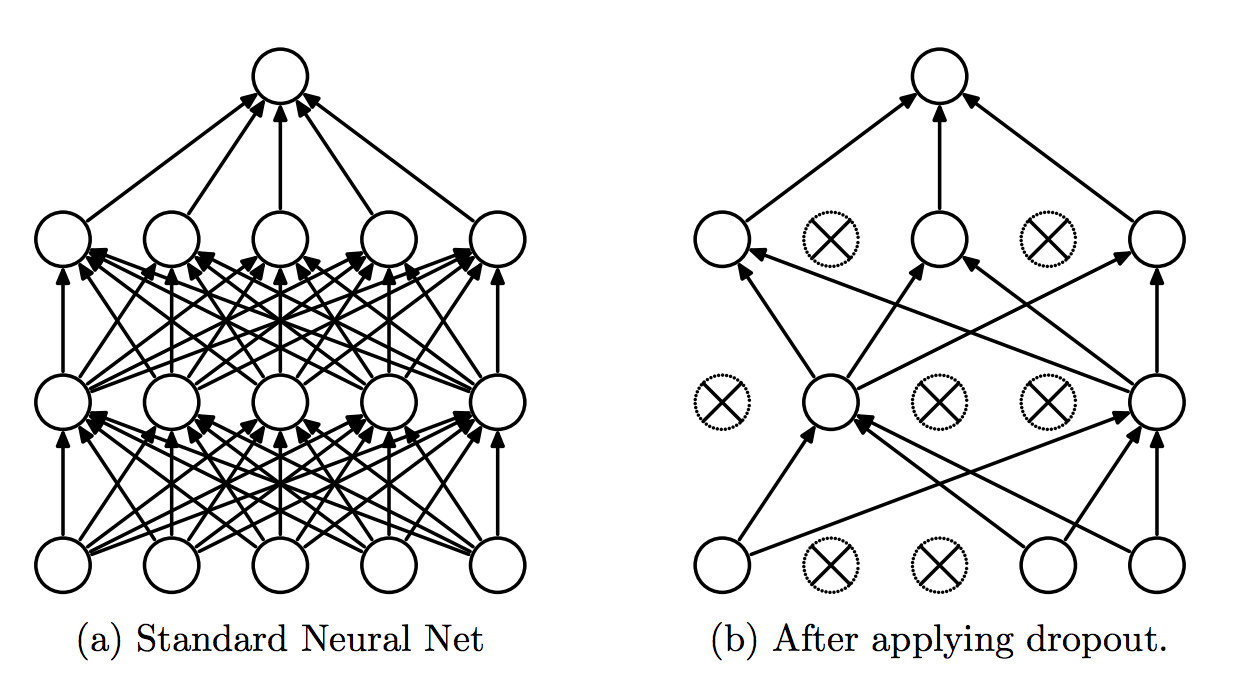

A motivation for dropout comes from a theory of the role of sex in evolution, where half genes come from each parent, combine and mutate a little. This turns out to be a bery efficient way which most advanced organisms used to evolve, although it seems to break up the complicated co-adaption that has survived through natural selection. But the truth is that the criterion for natural selection may not be individual fitness but rather mix-ability of genes, which is exactly the same as our neural network. We want a network that not only performs well on the existing training datasets, but we also expect it to predict reasonably in the unseen future. 

## 2. Model Description
With dropout, the feed-forward operation of neural networks can be described as :

$$r_j^{(l)} \sim \text{Bernoulli}(p),$$
$$\tilde y^{(l)} = r^{(l)} \odot y^{(l)},$$
$$z_i^{(l+1)} = w_i^{(l+1)}\tilde y^{(l)} + b_i^{(l+1)},$$
$$y_i^{(l+1)} = f(z_i^{(l+1)})$$

where $l$ is the index the hidden layers of the network, $z^{(l)}$ denote
the vector of inputs into layer $l$, $y^{(l)}$ denote the vector of outputs from layer $l$ ($y^{(0)} = x$ is the input). $w^{(l)}$ and $b^{(l)}$ are the weights and biases at layer $l$. $f$ is any activation function. And $\odot$ represents element-wise multiplication. Please see the detailed implementation in Section 3.

With this, the standard stochastic gradient descent procedure was used for training neural networks with dropout on mini-batches of training cases. For each epoch in SGD process, it is like training a new thinned neural network and through the moving, we actually shared the weight through the whole collection of networks. "Mean network" was used for testing, which contains all of the hidden units with their outgoing weights scaled down according to the retention probability chosen in the dropout process instead of averaging over a large number of dropout networks. Please see the detailed implementation in Section 4, where we performed dropout on a multilayer perceptron and a convolutional neural network.

It is shown that deep NNs with dropout applied before every weight layer are mathematically equivalent to approximate variational inference in the deep Gaussian process marginalised over its covariance function parameters ([[2](#Reference)]). 

The related Gaussian process could be described as below:

$$F \vert X, W_1, b \sim N(0, K(X,X))$$
$$Y \vert F \sim N(F, \tau^{-1}I_N)$$
Introduing $W_1$, which is a matrix parameterizing the covariance function K:
$$ p(Y\vert X) = \int p(Y\vert F)p(F\vert W_1, b, X)p(W_1)p(b)$$
Introduing $W_2$, another matrix that get the integration rid of F:
$$ p(Y\vert X) = \int p(Y\vert X, W_1, W_2, b)p(W_1)p(W_2)p(b)$$
To perform variational inference in our approximate model we need to define a variational distribution $q(W_1, W_2, b) := q(W_1)q(W_2)q(b)$, where $q(W_1)$ and $q(W_2)$ are defined as a Gaussian mixture model with two components, factorized over dimensinality of $W_1$ and $W_2$. For example: 

$$q(W_1) = \prod_{q=1}^{Q}q(w_q) $$
$$ q(w_q) = p_1N(m_q, \sigma^2I_K) + (1-p_1)N(0,\sigma^2I_K)$$

with some probability $p_1 \in [0, 1]$, scalar $\sigma > 0$ and $m_q ∈ R^K $.

In dropout model, the input was weighted by some weight matrix and then pass into some non-linear function, which is the same as what we did with the parameterizing matrix and covariance function. The output of the non-linear function would be the input of the next hidden layer. When we implement dropout, we actually created a binary vector to decide which hidden unit would be passed to the next layer, which is similar to what we did for the variational inference， sampling from that Gaussian mixture model. With this setup, we update the parameters by minimizing some loss function we choose, just as minimizing KL divergence in Gaussian process approximation. 

Based on this similarity, we can actually further derive it and obtain uncertainty of deep neural networks. Using moment-matching to estimate the predictive distribution is equivalent to performing $T$ stochastic forward passes through the network and averaging the results in practice([[2](#Reference)]).  So we can simply collect the results of stochastic forward passes through the model to estimate the predictive mean and predictive uncertainty. 


## 3. Dropout Implementation

All our implementations are based on PyTorch. The model training is on GPU and all other tasks are on CPU (so readers who don't have GPUs can run our notebook). To switch between GPU/CPU, you can add/remove `.cuda()` in the code.

### Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import pymc3 as pm

### Dropout Implementation

Below is the dropout layer we implemented, based on PyTorch.

We should multiply the dropout output by $\frac{1}{1-p}$ where $p$ is the dropout rate to compensate for the dropped neurons. We implemented a dropout layer below, it should have same functionality as `nn.Dropout` in Pytorch.

We used `MyDropout` in our first example network as a demonstration of its functionality; we managed to reproduce the results when replacing `MyDropout` by `nn.Dropout` (data not shown). We used `nn.Dropout` for all remaining networks since `nn.Dropout` is more efficient than our implementation.

In [2]:
class MyDropout(nn.Module):
    def __init__(self, p=0.5):
        super(MyDropout, self).__init__()
        self.p = p
        # multiplier is 1/(1-p). Set multiplier to 0 when p=1 to avoid error...
        if self.p < 1:
            self.multiplier_ = 1.0 / (1.0-p)
        else:
            self.multiplier_ = 0.0
    def forward(self, input):
        # if model.eval(), don't apply dropout
        if not self.training:
            return input
        
        # So that we have `input.shape` numbers of Bernoulli(1-p) samples
        selected_ = torch.Tensor(input.shape).uniform_(0,1)>self.p
        
        # To support both CPU and GPU.
        if input.is_cuda:
            selected_ = Variable(selected_.type(torch.cuda.FloatTensor), requires_grad=False)
        else:
            selected_ = Variable(selected_.type(torch.FloatTensor), requires_grad=False)
            
        # Multiply output by multiplier as described in the paper [1]
        return torch.mul(selected_,input) * self.multiplier_

## 4. Dropout as Regularization

In this section, we want to show dropout can be used as a regularization technique for deep neural networks. It can reduce the overfitting and make our network perform better on test set (**like L1 and L2 regularization we saw in AM207 lectures**). We will first do a multilayer perceptron (fully connected network) to show dropout works and then do a LeNet (a convolutional neural network) to show dropout is also useful for different network architectures.

We use MNIST (as we see in homework) as our sample dataset. This dataset has images of hand written digits and the labels of the ground truth digits. Code cell below loads the dataset and shows 10 training samples.

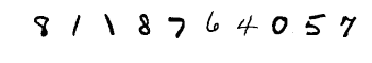

label: [8 1 1 8 7 6 4 0 5 7]
image data shape: (1, 28, 28)


In [3]:
transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize((0, 0, 0), (1, 1, 1))])

trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

# Visualize 10 image samples in MNIST dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
dataiter = iter(trainloader)
images, labels = dataiter.next()
# plot 10 sample images
_,ax = plt.subplots(1,10)
ax = ax.flatten()
iml = images[0].numpy().shape[1]
[ax[i].imshow(np.transpose(images[i].numpy(),(1,2,0)).reshape(iml,-1),cmap='Greys') for i in range(10)]
[ax[i].set_axis_off() for i in range(10)]
plt.show()
print('label:',labels[:10].numpy())
print('image data shape:',images[0].numpy().shape)

### 4.1 Multilayer Perceptron

We first build a multilayer perceptron (MLP), and use the code below to define the network as described in paper [[1](#Reference)]. This network has 2 hidden layer with 800 hidden units per hidden layer. To show our implementation of Dropout above is correct, we use `MyDropout` here.

In [4]:
class MLP(nn.Module):
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0]):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module("dropout0",MyDropout(p=droprates[0]))
        self.model.add_module("input", nn.Linear(28*28, hidden_layers[0]))
        self.model.add_module("tanh", nn.Tanh())
        
        # Add hidden layers
        for i,d in enumerate(hidden_layers[:-1]):
            self.model.add_module("dropout_hidden"+str(i+1), MyDropout(p=droprates[1]))
            self.model.add_module("hidden"+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.model.add_module("tanh_hidden"+str(i+1), nn.Tanh())
        self.model.add_module("final",nn.Linear(hidden_layers[-1], 10))        
        
    def forward(self, x):
        # Turn to 1D
        x = x.view(x.shape[0], 28*28)
        x = self.model(x)
        return x

Next, we implement a sklearn-like classifier for training and keep track of the **full test results** after each epoch.

In [5]:
class MLPClassifier:
    def __init__(self, hidden_layers=[800, 800], droprates=[0, 0], batch_size=128, max_epoch=10, \
                 lr=0.1, momentum=0):
        # Wrap MLP model
        self.hidden_layers = hidden_layers
        self.droprates = droprates
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = MLP(hidden_layers=hidden_layers, droprates=droprates)
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr, momentum=momentum)
        self.loss_ = []
        self.test_accuracy = []
        self.test_error = []
        
    def fit(self, trainset, testset, verbose=True):
        # Training, make sure it's on GPU, otherwise, very slow...
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test.cuda()
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
            self.loss_.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
            y_test_pred = self.predict(X_test).cpu()
            self.test_accuracy.append(np.mean(y_test == y_test_pred))
            self.test_error.append(int(len(testset)*(1-self.test_accuracy[-1])))
            if verbose:
                print('Test error: {}; test accuracy: {}'.format(self.test_error[-1], self.test_accuracy[-1]))
        return self
    
    def predict(self, x):
        # Used to keep all test errors after each epoch
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred
    
    def __str__(self):
        return 'Hidden layers: {}; dropout rates: {}'.format(self.hidden_layers, self.droprates)

Paper [[1](#Reference)] tried three sets of experiments. One with **no dropout**, one with **dropout in hidden layers** and one with **dropout in both hidden layers and input**. We use the same dropout rate as in paper [[1](#Reference)]. We define those three networks in the code section below.

In [6]:
hidden_layers = [800, 800]

### Below is training code, uncomment to train your own model... ###
### Note: You need GPU to run this section ###
'''
# Define networks
mlp1 = [MLPClassifier(hidden_layers, droprates=[0, 0], max_epoch=1500), 
        MLPClassifier(hidden_layers, droprates=[0, 0.5], max_epoch=1500),
        MLPClassifier(hidden_layers, droprates=[0.2, 0.5], max_epoch=1500)]
        
# Training, set verbose=True to see loss after each epoch.
[mlp.fit(trainset, testset,verbose=False) for mlp in mlp1]

# Save torch models
for ind, mlp in enumerate(mlp1):
    torch.save(mlp.model, 'mnist_mlp1_'+str(ind)+'.pth')
    # Prepare to save errors
    mlp.test_error = list(map(str, mlp.test_error))

# Save test errors to plot figures
open("mlp1_test_errors.txt","w").write('\n'.join([','.join(mlp.test_error) for mlp in mlp1])) 
'''

# Load saved models to CPU
mlp1_models = [torch.load('mnist_mlp1_'+str(ind)+'.pth',map_location={'cuda:0': 'cpu'}) for ind in [0,1,2]]

# Load saved test errors to plot figures.
mlp1_test_errors = [error_array.split(',') for error_array in open("mlp1_test_errors.txt","r").read().split('\n')]
mlp1_test_errors = np.array(mlp1_test_errors,dtype='f')

After the training, we can plot the number of error predictions on test set after each epoch for all three networks as in paper [[1](#Reference)].

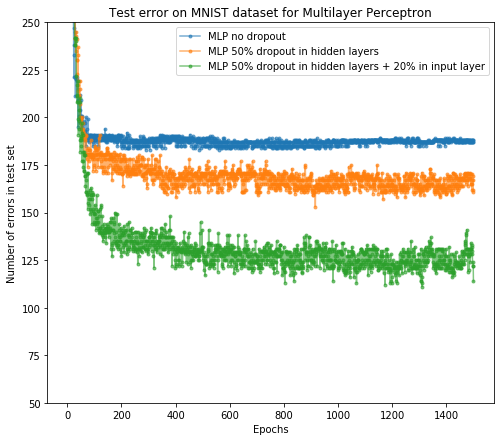

In [7]:
labels = ['MLP no dropout', 
          'MLP 50% dropout in hidden layers', 
          'MLP 50% dropout in hidden layers + 20% in input layer']

plt.figure(figsize=(8, 7))
for i, r in enumerate(mlp1_test_errors):
    plt.plot(range(1, len(r)+1), r, '.-', label=labels[i], alpha=0.6);
plt.ylim([50, 250]);
plt.legend(loc=1);
plt.xlabel('Epochs');
plt.ylabel('Number of errors in test set');
plt.title('Test error on MNIST dataset for Multilayer Perceptron')
plt.show()

From the result, we see dropout as regularization is useful and it successfully improves the network accuracy on the test set. In addition, further adding the dropout layer after the input layer will help as well.

### 4.2 Convolutional Neural Network (LeNet)

Next, we show dropout can improve test performance in convolutional neural networks as well. Here, we implement a simple LeNet for demonstration. The LeNet architecture is shown below.

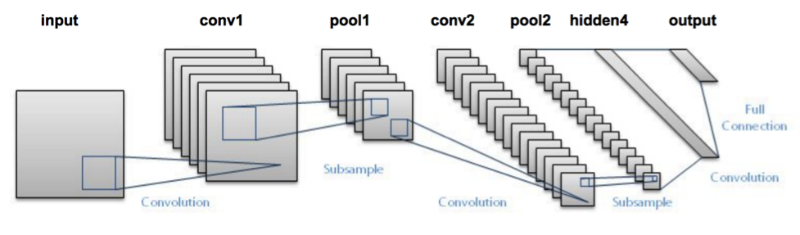

source: https://blog.dataiku.com/deep-learning-with-dss

We first calculate the dimension of images after going through convolutional layers and pooling layers since we need to specify in and out dimensions for linear layers in `pytorch`.

In [8]:
def caloutdim(hin, kernel_size, stride=1, padding=0, dilation=1):
    return int(np.floor((hin+2*padding-dilation*(kernel_size-1)-1)/stride+1))

d = [28]
d.append(caloutdim(d[-1], 5, padding=2))
d.append(caloutdim(d[-1], 2, 2))
d.append(caloutdim(d[-1], 5, padding=2))
d.append(caloutdim(d[-1], 2, 2))
print(d)

[28, 28, 14, 14, 7]


The code cell below defines the LeNet. We use `nn.Dropout2d` here. This is equivalent to `MyDropout` except it's for 2D and has better efficiency.

In [9]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

class LeNet(nn.Module):
    def __init__(self, droprate=0.5):
        super(LeNet, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('conv1', nn.Conv2d(1, 20, kernel_size=5, padding=2))
        self.model.add_module('dropout1', nn.Dropout2d(p=droprate))
        self.model.add_module('maxpool1', nn.MaxPool2d(2, stride=2))
        self.model.add_module('conv2', nn.Conv2d(20, 50, kernel_size=5, padding=2))
        self.model.add_module('dropout2', nn.Dropout2d(p=droprate))
        self.model.add_module('maxpool2', nn.MaxPool2d(2, stride=2))
        self.model.add_module('flatten', Flatten())
        self.model.add_module('dense3', nn.Linear(50*7*7, 500))
        self.model.add_module('relu3', nn.ReLU())
        self.model.add_module('dropout3', nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(500, 10))
        
    def forward(self, x):
        return self.model(x)

Similar as above, we implement a sklearn-like classifier for LeNet.

In [10]:
class LeNetClassifier:
    def __init__(self, droprate=0.5, batch_size=128, max_epoch=300, lr=0.01):
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = LeNet(droprate)
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.loss_ = []
        self.test_error = []
        self.test_accuracy = []
        
    def fit(self, trainset, testset, verbose=True):
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test.cuda()
        print(self.model)
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.data[0]
            self.loss_.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
            y_test_pred = self.predict(X_test).cpu()
            self.test_accuracy.append(np.mean(y_test == y_test_pred))
            self.test_error.append(int(len(testset)*(1-self.test_accuracy[-1])))
            if verbose:
                print('Test error: {}; test accuracy: {}'.format(self.test_error[-1], self.test_accuracy[-1]))
        return self
    
    def predict(self, x):
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred

And the training code is below. We load our trained models here.

In [11]:
### Below is training code, uncomment to train your own model... ###
### Note: You need GPU and CUDA to run this section ###
'''
# Define networks
lenet1 = [LeNetClassifier(droprate=0, max_epoch=1500),
          LeNetClassifier(droprate=0.5, max_epoch=1500)]
        
# Training, set verbose=True to see loss after each epoch.
[lenet.fit(trainset, testset,verbose=False) for lenet in lenet1]

# Save torch models
for ind, lenet in enumerate(lenet1):
    torch.save(lenet.model, 'mnist_lenet1_'+str(ind)+'.pth')
    # Prepare to save errors
    lenet.test_error = list(map(str, lenet.test_error))

# Save test errors to plot figures
open("lenet1_test_errors.txt","w").write('\n'.join([','.join(lenet.test_error) for lenet in lenet1])) 
'''

# Load saved models to CPU
lenet1_models = [torch.load('mnist_lenet1_'+str(ind)+'.pth', map_location={'cuda:0': 'cpu'}) for ind in [0,1]]

# Load saved test errors to plot figures.
lenet1_test_errors = [error_array.split(',') for error_array in 
                      open("lenet1_test_errors.txt","r").read().split('\n')]
lenet1_test_errors = np.array(lenet1_test_errors,dtype='f')

After the training, we can plot the number of error predictions on test set after each epoch for all networks. Here we overlay the LeNet result on the MLP network we just showed.

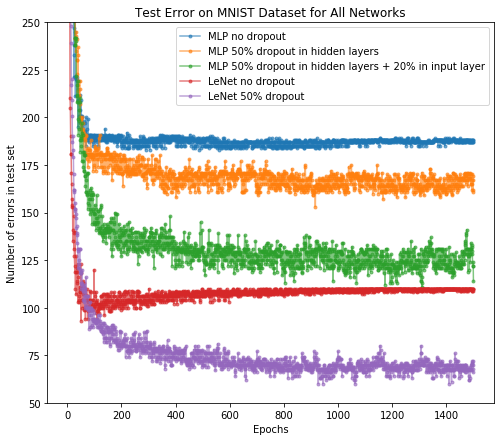

In [12]:
labels = ['MLP no dropout', 
          'MLP 50% dropout in hidden layers', 
          'MLP 50% dropout in hidden layers + 20% in input layer',
          'LeNet no dropout',
          'LeNet 50% dropout']

plt.figure(figsize=(8, 7))
for i, r in enumerate(mlp1_test_errors.tolist() + lenet1_test_errors.tolist()):
    plt.plot(range(1, len(r)+1), r, '.-', label=labels[i], alpha=0.6);
plt.ylim([50, 250]);
plt.legend(loc=1);
plt.xlabel('Epochs');
plt.ylabel('Number of errors in test set');
plt.title('Test Error on MNIST Dataset for All Networks')
plt.show()

As we can see, 
1. Dropout in hidden layers can reduce test errors in standard feedforward network (i.e., MLP); we can further improve the test performance by applying dropout on the input layer.
2. LeNet performs better than MLP even without dropout, but overfitting occurs. Dropout significantly improves the test performance, which demonstrates dropout as an effective regularization method in CNNs.

## 5. Dropout as Bayesian Approximation

### 5.1 Dropout as Bayesian Approximation in Classification Task

Here we use the models (MLP and LeNet) that we trained above for the classification of MNIST digits to demonstrate how we can acquire model uncertainty through dropout.

We evaluate the models on twelve continuously rotated images of the digit 1 (as shown below). These images correspond to X axis in the latter scatter figure. 

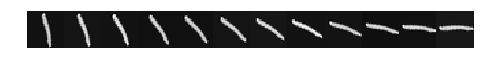

In [13]:
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
X_test, y_test = iter(testloader).next()
X_test = X_test.numpy()
X1 = np.array([rotate(X_test[9978].squeeze(), i, reshape=False) for i in range(50, 130, 7)])
X1 = X1.reshape(X1.shape[0], 1, X1.shape[1], X1.shape[2])

plt.figure(figsize=(8, 1))

gs = gridspec.GridSpec(1, 12)
gs.update(wspace=0, hspace=0)

for i in range(len(X1)):
    plt.subplot(gs[i])
    plt.imshow(X1.squeeze()[i], cmap='gray');
    plt.axis('off');

For each model, we simulate 1000 stochastic forward passes, and visualize distributions of the softmax inputs and the softmax outputs for each of the top classes.

Below is the function doing the simulation.

In [14]:
def predict_class(model, X):
    model = model.eval()
    outputs = model(Variable(X))
    _, pred = torch.max(outputs.data, 1)
    model = model.train()
    return pred.numpy()

def predict(model, X, T=1000):
    standard_pred = predict_class(model, X)
    y1 = []
    y2 = []
    for _ in range(T):
        _y1 = model(Variable(X))
        _y2 = F.softmax(_y1, dim=1)
        y1.append(_y1.data.numpy())
        y2.append(_y2.data.numpy())
    return standard_pred, np.array(y1), np.array(y2)

#### 5.1.1 MLP 50% dropout in hidden layers + 20% in input layer

We get this model (50% dropout in hidden layers and 20% dropout in input layer) from [section 4.1](#4.1-Multilayer-Perceptron). First, let's see how well the model does on the rotated digit '1'.

In [15]:
model = mlp1_models[2]

# Need to flatten X1 before feeding into MLP
y1_pred, y1_si, y1_so = predict(model, torch.from_numpy(X1.reshape(-1,784)))
print('Predictions: {}'.format(y1_pred))

Predictions: [1 1 1 1 1 3 3 7 7 7 7 7]


Now let's plot and see what information we can get from this. We will plot the distribution of output values corresponding to labels '1', '7' and '3' at the **layer just before softmax** and at the **softmax layer**.

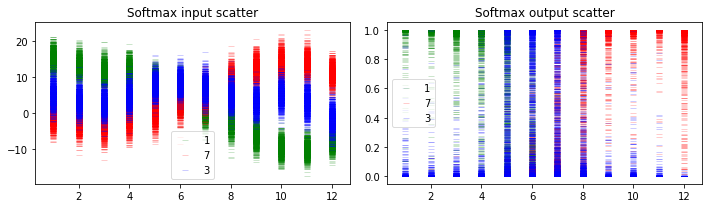

In [16]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax output scatter');
plt.legend(framealpha=0.7);

plt.tight_layout();

There are three different classes shown in the prediction results, 1, 7 and 3. As shown in the figure above, if they are  well separated in the softmax output, we can get high confidence for predictions. However in some cases where there is overlap among the uncertainty envelopes for different classes, the uncertainty of prediction result will become higher as shown in middle ones in both plots.

#### 5.1.2 LeNet 50% dropout

We get this model (50% dropout in hidden layers) from [section 4.2](#4.2-Convolutional-Neural-Network-%28LeNet%29). First, let's see how well the model does on the rotated digit '1'.

In [17]:
model = lenet1_models[1]
y1_pred, y1_si, y1_so = predict(model, torch.from_numpy(X1))
print('Predictions: {}'.format(y1_pred))

Predictions: [1 1 1 1 1 1 7 7 7 7 7 7]


Now let's do simulations to get the uncertainty of the output, just like above.

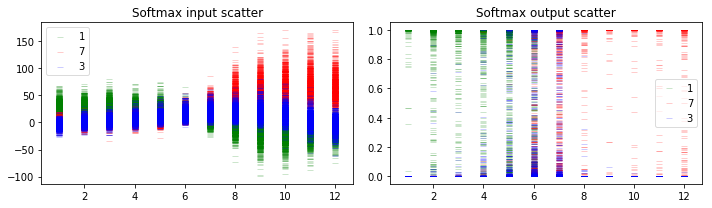

In [18]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_si.shape[0]), y1_si[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 1].flatten(), \
            color='g', marker='_', linewidth=None, alpha=0.2, label='1');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 7].flatten(), \
            color='r', marker='_', linewidth=None, alpha=0.2, label='7');
plt.scatter(np.tile(np.arange(1, 13), y1_so.shape[0]), y1_so[:, :, 3].flatten(), \
            color='b', marker='_', linewidth=None, alpha=0.2, label='3');
plt.title('Softmax output scatter');
plt.legend(framealpha=0.7);

plt.tight_layout();

#### 5.1.3 Discussion

When the uncertainty envelop of the top class is far away from that of other classes (e.g., the leftmost image), we can make predictions with high confidence. When the uncertainty envelopes for different classes intersect with each other (e.g., the middle input images), the softmax output can be as large as the entire space even though the softmax output can be arbitrarily high.

Although we got different predictions for the middle images, the softmax output scatters show that we make those predictions with high uncertainty. And the softmax output scatters for 2 different networks look similar, although the softmax input scatters look sightly different.

As mentioned by the authors, such uncertainty information can help us obtain higher classification accuracies (not shown in this paper), and help us check whether we correctly specify the model or whether we have enough data.

### 5.2. Dropout as Bayesian Approximation in Regression Task

In this part, we show how to use dropout to obtain model uncertainty in regression tasks.

Here we use the $\text{CO}_2$ concentrations dataset (example in [[2](#Reference)]) for demonstration. We load training set (provided in [[2](#Reference)]) and generate test data that is very different from the training set. The training dataset can be downloaded from our Google Drive shown at the beginning of this notebook.

In [19]:
f = h5py.File('co2_data.h5', 'r')
data_train = np.concatenate((f['data'].value, f['label'].value), axis=1)
f.close()
X_train = data_train[:, 0].reshape(-1, 1)
y_train = data_train[:, 1].reshape(-1, 1)
print(data_train.shape)

X_test = np.arange(-1.72, 3.51, 0.01).reshape(-1, 1)

(272, 2)


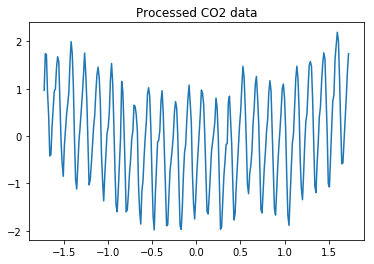

In [20]:
plt.plot(data_train[:, 0], data_train[:, 1]);
plt.title('Processed CO2 data');

We train a multilayer perceptron with 5 hidden layers, 1024 units in each layer, ReLU/Tanh non-linearities, and dropout with probability 0.2 after each weight layer. As pointed out by paper [[2](#Reference)], similar results can be obtained when using 4 hidden layers or dropout probability of 0.1.

We define the network with code below.

In [21]:
class MLP2(nn.Module):
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu'):
        super(MLP2, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('input', nn.Linear(1, hidden_layers[0]))
        if activation == 'relu':
            self.model.add_module('relu0', nn.ReLU())
        elif activation == 'tanh':
            self.model.add_module('tanh0', nn.Tanh())
        for i in range(len(hidden_layers)-1):
            self.model.add_module('dropout'+str(i+1), nn.Dropout(p=droprate))
            self.model.add_module('hidden'+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            if activation == 'relu':
                self.model.add_module('relu'+str(i+1), nn.ReLU())
            elif activation == 'tanh':
                self.model.add_module('tanh'+str(i+1), nn.Tanh())
        self.model.add_module('dropout'+str(i+2), nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(hidden_layers[i+1], 1))
        
    def forward(self, x):
        return self.model(x)

Similar as last section, we implement a sklearn-like regressor for this MLP.

In [22]:
class MLP2Regressor:
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu', \
                 max_epoch=1000000, lr=0.0001, weight_decay=1e-6):
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = MLP2(hidden_layers=hidden_layers, droprate=droprate, activation=activation)
        self.model.cuda()
        self.criterion = nn.MSELoss().cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        
    def fit(self, X_train, y_train, verbose=True):
        X = Variable(torch.from_numpy(X_train).type(torch.FloatTensor)).cuda()
        y = Variable(torch.from_numpy(y_train).type(torch.FloatTensor)).cuda()
        print(self.model)
        for epoch in range(self.max_epoch):
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, loss.data[0]))
        return self

And the training code is below. We load our trained models here.

In [23]:
### Below is training code, uncomment to train your own model... ###
### Note: You need GPU and CUDA to run this section ###
'''
# Define networks
mlp2 = [MLP2Regressor(activation='relu'),
        MLP2Regressor(activation='tanh')]
        
# Training, set verbose=True to see loss after each epoch.
[mlp.fit(X_train, y_train,verbose=False) for mlp in mlp2]

# Save torch models
for ind, mlp in enumerate(mlp2):
    torch.save(mlp.model, 'co2_mlp2_'+str(ind)+'.pth')
'''

# Load saved models to CPU
mlp2_models = [torch.load('co2_mlp2_'+str(ind)+'.pth',map_location={'cuda:0': 'cpu'}) for ind in [0,1]]

Below is the function doing the simulation for the regressors. Here, we simulate 10000 times. The simulation is very slow since we have many data points.

In [24]:
def predict_reg(model, X, T=10000):
    X = Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda())
    model = model.train()
    Yt_hat = np.array([model(X).data.cpu().numpy() for _ in range(T)]).squeeze()
    model = model.eval()
    y_pred = model(X).data.cpu().numpy()
    model = model.train()
    return y_pred, Yt_hat

We stored the simulation results and load here. To generate simulation results yourself, uncomment the code below.

In [25]:
# Simulation below is very slow. Run with GPU! #
### Uncomment to simulate ###
'''
mlp2_models = [torch.load('co2_mlp2_'+str(ind)+'.pth') for ind in [0,1]]
y_relu_pred, y_hat = predict_reg(mlp2_models[0], X_test)
y_relu_mc = y_hat.mean(axis=0)
y_relu_mc_std = y_hat.std(axis=0)
y_tanh_pred, y_hat = predict_reg(mlp2_models[1], X_test)
y_tanh_mc = y_hat.mean(axis=0)
y_tanh_mc_std = y_hat.std(axis=0)
results = [y_relu_pred,y_relu_mc,y_relu_mc_std,y_tanh_pred,y_tanh_mc,y_tanh_mc_std]
results = [x.reshape(-1).astype(str).tolist() for x in results]
open("mlp2_sim_results.txt","w").write('\n'.join([','.join(res) for res in results]))
'''

# Load saved simulation results
results = [res_array.split(',') for res_array in 
                      open("mlp2_sim_results.txt","r").read().split('\n')]
results = np.array(results,dtype='f')
y_relu_pred,y_relu_mc,y_relu_mc_std,y_tanh_pred,y_tanh_mc,y_tanh_mc_std = results

We can compare the uncertainty we get through dropout with the uncertainty we get from a Gaussian process (GP).

In [26]:
import pickle

with pm.Model() as gp_model:
    l = pm.HalfCauchy('l', 0.05)
    eta = pm.HalfCauchy('eta', 1)
    sigma = pm.HalfCauchy('sigma', 0.1)
    gp = pm.gp.Marginal(cov_func=(eta ** 2) * pm.gp.cov.ExpQuad(1, l))
    obs = gp.marginal_likelihood('obs', X=X_train, y=y_train.squeeze(), noise=sigma, is_observed=True)

# Code below trains the GP model, it's very slow. So we load the trained model and comment this out
'''
with gp_model:
    step = pm.NUTS(target_accept=0.95)
    trace1 = pm.sample(5000, tune=2000, step=step, njobs=2)
with open('co2_gp.pkl', 'wb') as output:
            pickle.dump((gp_model,trace1), output, protocol=pickle.HIGHEST_PROTOCOL)
'''
with open('co2_gp.pkl', 'rb') as input_:
    gp_model, trace1 = pickle.load(input_)

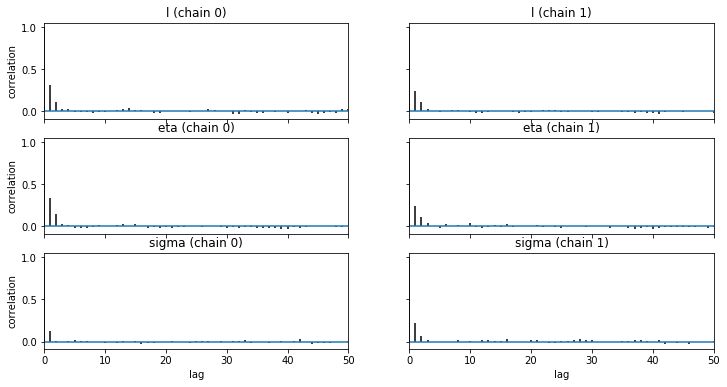

In [27]:
pm.autocorrplot(trace1, max_lag=50);

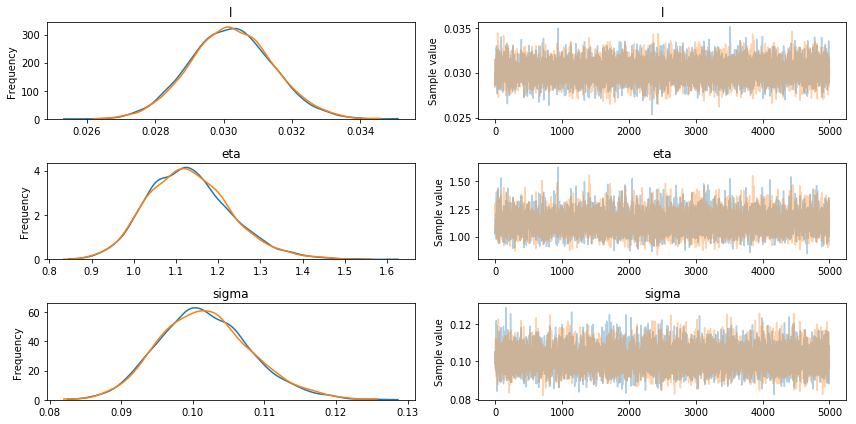

In [28]:
pm.traceplot(trace1);

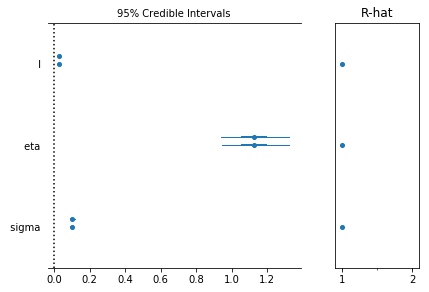

In [29]:
pm.forestplot(trace1);

The above tests demonstrate the convergence of the model.

In [30]:
# PPC below is very slow. So we load saved results #
### Uncomment to simulate ###
'''
with gp_model:
    y_gp = gp.conditional('y_pred', Xnew=X_test, pred_noise=True)
    gp_samples = pm.sample_ppc(trace1, vars=[y_gp], samples=10000)
ppc = gp_samples['y_pred']
y_gp_pred = ppc.mean(axis=0)
y_gp_std = ppc.std(axis=0)
results = [y_gp_pred,y_gp_std]
results = [x.reshape(-1).astype(str).tolist() for x in results]
open("gp_sim_results.txt","w").write('\n'.join([','.join(res) for res in results]))
'''

# Load saved PPC results
results = [res_array.split(',') for res_array in 
                      open("gp_sim_results.txt","r").read().split('\n')]
results = np.array(results,dtype='f')
y_gp_pred,y_gp_std = results

Next, we compare those models for regression.

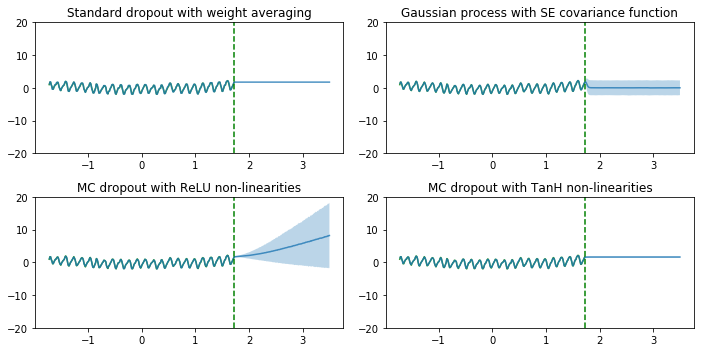

In [31]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.title('Standard dropout with weight averaging');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 2)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_gp_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_gp_pred-2*y_gp_std, y_gp_pred+2*y_gp_std, alpha=0.3);
plt.title('Gaussian process with SE covariance function');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 3)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_relu_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_relu_mc-2*y_relu_mc_std, y_relu_mc+2*y_relu_mc_std, alpha=0.3);
plt.title('MC dropout with ReLU non-linearities');
plt.ylim([-20, 20]);

plt.subplot(2, 2, 4)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_tanh_mc-2*y_tanh_mc_std, y_tanh_mc+2*y_tanh_mc_std, alpha=0.3);
plt.title('MC dropout with TanH non-linearities');
plt.ylim([-20, 20]);

plt.tight_layout();

As we can see, the dropout network with ReLU non-linearities and the Gaussian process (GP) model successfully show the uncertainty for points away from the training data points. The uncertainty estimates are different since they correpond to different Gaussian process covariance functions. The uncertainty of dropout network with Tanh non-linearities doesn't increase far from the data, presumably because Tanh saturates whereas ReLU does not, as explained by in [[2](#Reference)]

## 6. Conclusions

This tutorial focuses on paper [[1](#Reference)] and [[2](#Reference)]. We showed the math, implementation and usage of dropout and the details of dropout as regularization. The dropout as regularization successfully reduced the overfitting of deep learning models and we achived higher accuracy on the test set. Regularization is not new, and we have seen other regularization techniques (L1 and L2) in AM207 lectures.

In addition, we showed dropout as Bayesian approximation (obtain model uncertainty [[2](#Reference)]). For regression tasks, we also compared the deep neural network with dropout as Bayesian approximation with the Gaussian Process (GP) we learnt in AM207. From the figure, we see both models successfully show the uncertainty for points away from the training data points. According to [[2](#Reference)], the uncertainty estimates are different since they correpond to different Gaussian process covariance functions. Since GP and neural networks with dropout are similar, in large dataset, we can use neural networks with dropout to approximate GP (with large amount of data, GP has very large covariance matrix and it's hard to fit).

## Reference

[1] [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/pdf/1207.0580.pdf)

[2] [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/pdf/1506.02142.pdf)

[3] [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf)